In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Exploration

We then load the Breast Cancer Wisconsin Diagnostic Dataset from `sklearn.datasets`.

In [ ]:
# Load dataset
data = load_breast_cancer()
print(data.DESCR)

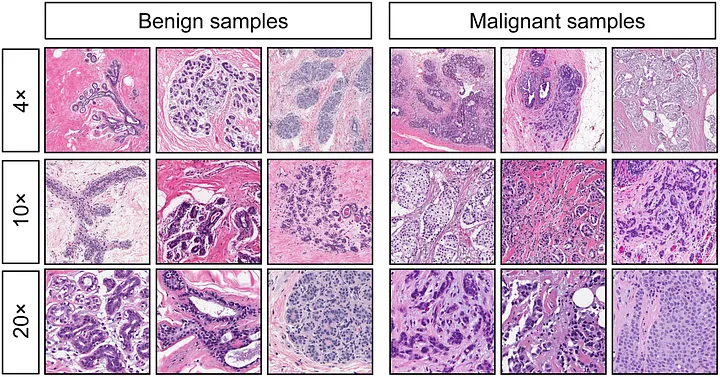

We convert the dataset into a pandas.DataFrame, assigning appropriate column names and adding both the target variable (0 for malignant, 1 for benign) and human-readable target names.

In [ ]:

# Create DataFrame with features
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add target column
df['target'] = data.target

# Optionally, map the target values to class names
df['target_name'] = df['target'].map(dict(enumerate(data.target_names)))

# Display the first few rows
print(df.head())


[Paper explaining](https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf;jsessionid=ED3D95A80360B4B45F05F2737ECC7B22?sequence=1) how feature are extracted.

In [ ]:
df.describe()


### Data Quality Check

Here, we check the dataset for:

- Null values (NaNs) – which could break the ML pipeline.

- Infinite values – which can distort statistics and cause model instability.

No missing or infinite values indicate a clean dataset ready for analysis.

In [ ]:
print("🔍 Data Quality Check\n" + "-"*40)
    
# Check for nulls
null_counts = df.isnull().sum()
has_nulls = df.isnull().values.any()
print("📌 Null (NaN) values per column:")
print(null_counts[null_counts > 0] if has_nulls else "✅ No null values found.")

# Select numeric columns only for isinf check
numeric_df = df.select_dtypes(include=[np.number])

# Check for infinite values
inf_counts = np.isinf(numeric_df).sum()
has_infs = np.isinf(numeric_df).values.any()
print("\n📌 Infinite values per column (numeric only):")
print(inf_counts[inf_counts > 0] if has_infs else "✅ No infinite values found.")

### Class Distribution
We visualize the class distribution of diagnoses (malignant vs. benign). This helps us identify if there's a class imbalance, which is common in medical datasets.

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(6,4))
sns.countplot(x='target_name', data=df, palette='pastel')
plt.title("Class Distribution (Benign vs Malignant)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()


### Feature Distribution by Diagnosis
For selected features like mean radius, mean texture, and mean area, we plot distributions split by diagnosis.
This helps in visually identifying features that may distinguish between malignant and benign tumors.

In [ ]:
features_to_plot = ['mean radius', 'mean texture', 'mean area']

for feature in features_to_plot:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=feature, hue='target_name', kde=True, palette='husl', element='step')
    plt.title(f"Distribution of {feature} by Diagnosis")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()


### Correlation Heatmap
This heatmap shows how features correlate with each other and with the target.
Understanding correlation helps us:

- Reduce feature redundancy

- Identify strong predictors

In [ ]:
plt.figure(figsize=(12,10))
correlation = df.drop(columns=['target_name']).corr().abs()
sns.heatmap(correlation, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation with the target
corr_with_target = correlation['target'].drop('target')  # exclude 'target' itself

# Plot correlations
plt.figure(figsize=(16, 6))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.xticks(rotation=90)
plt.ylabel('Correlation with target')
plt.title('Feature Correlation with Diagnosis (Target)')
plt.tight_layout()
plt.show()


In [ ]:
top = corr_with_target.abs().sort_values(ascending=False).head(10)
print(f"Top features most correlated with the target:\n{top}")


In [ ]:
selected =  top.index.tolist() + ['target_name']
sns.pairplot(df[selected], hue='target_name', palette='Set2', diag_kind='kde')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()


## Model Development

### Data preparation

To mitigate bias from class imbalance, we downsample the majority class (benign) to match the minority class (malignant).
This ensures the model isn't biased toward predicting the majority class.

In [ ]:
from sklearn.utils import resample

# Separate classes
df_majority = df[df['target'] == 1]  # benign
df_minority = df[df['target'] == 0]  # malignant

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

# Combine balanced data
df_balanced = pd.concat([df_minority, df_majority_downsampled])

# Shuffle the DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['target_name'].value_counts())


In [ ]:
from sklearn.model_selection import train_test_split

# Drop non-numeric or unnecessary columns (like 'target_name')
X = df_balanced.drop(columns=['target', 'target_name'])  # Features
y = df_balanced['target']                                # Labels


We separate the data into:

- Training set (80%) for learning

- Test set (20%) for evaluating performance

We also stratify to preserve class proportions across both sets.

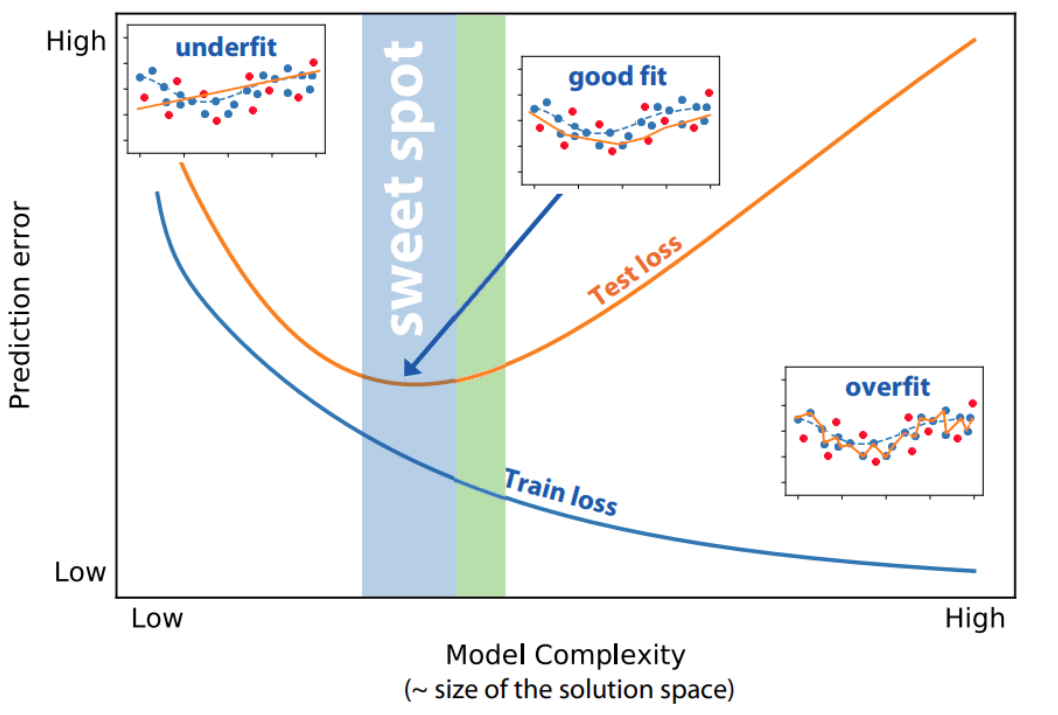

In [ ]:
# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
    stratify=y # 
    )

# Optional: Check class balance in splits
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("\nTest target distribution:\n", y_test.value_counts(normalize=True))


Standardization (zero mean, unit variance) is applied to features using StandardScaler.
This step is especially important for algorithms sensitive to feature scales (e.g. neural networks, etc.).

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training data, then transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Random Forest Classifier

Random Forest is an ensemble method (ensemble methods are powerful machine learning techniques that combine multiple models to improve the overall performance of a predictive model) that constructs a multitude of decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer # loads the dataset

# # Load the dataset
# data = load_breast_cancer()

# # Create a DataFrame from the dataset
# df = pd.DataFrame(data.data, columns=data.feature_names)
# df['target'] = data.target

# # Assuming the last column is the target and the rest are features
# X = df.iloc[:, :-1]
# y = df.iloc[:, -1]

# # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=2, random_state=42)
rf_clf.fit(X_train_scaled, y_train)
rf_y_pred = rf_clf.predict(X_test_scaled)


Some relevant terms for the classification:
- TP (True Positive)   - Model correctly predicts the positive class (e.g. cancer present).
- TN (True Negative)   - Model correctly predicts the negative class (e.g. cancer absent).
- FP (False Positive)  - Model incorrectly predicts positive (false alarm).
- FN (False Negative)  - Model incorrectly predicts negative (missed diagnosis).
  
The `classification_report` shows the following metrics for each class:

1. Precision
   
   Precision = TP / (TP + FP)
   Out of all predicted positives, how many were actually correct?
   High precision means few false positives.

2. Recall (also called Sensitivity or True Positive Rate)
   
   Recall = TP / (TP + FN)
   Out of all actual positives, how many were correctly identified?
   High recall means few false negatives (important in medical diagnoses).

3. F1-Score
   
   F1 = 2 * (Precision * Recall) / (Precision + Recall)
   The harmonic mean of precision and recall.
   Balances the trade-off between precision and recall.

4. Support
   The number of actual samples for each class in the dataset.
   Useful for knowing class balance and interpreting average scores.

Example:
If you're predicting cancer (1 = benign, 0 = malignant),
  - High precision for "malignant" means fewer false alarms.
  - High recall for "malignant" means fewer missed cancer cases.

N.B: When dealing with imbalanced classes, F1-score and recall are often more informative than accuracy.


In [ ]:

# Evaluation
print("Random Forest Classifier:")
print(classification_report(y_test, rf_y_pred))


In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, (rf_y_pred > 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)

# Plot
plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

Feature importance refers to techniques that assign a score to input features based on their usefulness in predicting the target variable.

In Random Forests, the Gini index is used to evaluate the quality of a split in a decision tree and to determine feature importance. It measures the probability of misclassifying a randomly chosen element in a dataset. A Gini index of 0 indicates a pure node (all data points belong to the same class), while a Gini index of 0.5 (in the case of a binary classification) indicates maximum impurity (an equal distribution of classes). 

In [ ]:

# Feature importance
import matplotlib.pyplot as plt

# Random Forest feature importance
rf_feature_importance = rf_clf.feature_importances_
rf_indices = np.argsort(rf_feature_importance)[::-1]


# Plotting feature importance
plt.figure(figsize=(14, 5))

plt.title("Random Forest Feature Importance")
plt.bar(range(X.shape[1]), rf_feature_importance[rf_indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[rf_indices], rotation=90)

print("Random Forest Accuracy:", rf_clf.score(X_test, y_test))

acc_rf = rf_clf.score(X_test, y_test)

plt.tight_layout()
plt.show()

In [ ]:
# evaluate roc curves for the two classifiers
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate ROC AUC scores
rf_y_pred_proba = rf_clf.predict_proba(X_test_scaled)[:,1]
print(rf_y_pred_proba)


In [ ]:

# Create DataFrame for plotting
import pandas as pd
df_plot = pd.DataFrame({
    'Probability': rf_y_pred_proba,
    'True Label': y_test
})
df_plot['Class'] = df_plot['True Label'].map({0: 'Malignant', 1: 'Benign'})

#  Plot discriminative distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=df_plot, x='Probability', hue='Class', bins=25, kde=True, palette='Set2', common_norm=False)
plt.title('Discriminative Probability Distribution by True Class')
plt.xlabel('Predicted Probability (Benign)')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


The ROC (Receiver Operating Characteristic) curve is built from:

1. True Positive Rate (TPR) — also called Recall or Sensitivity
   TPR = TP / (TP + FN)
   Measures the proportion of actual positives correctly identified.

2. False Positive Rate (FPR)
   FPR = FP / (FP + TN)
   Measures the proportion of actual negatives incorrectly identified as positive.

3. Thresholds
   ROC is generated by varying the classification threshold (e.g., from 0 to 1).
   At each threshold, TPR and FPR are computed to create the curve.

A good model has high TPR and low FPR, forming a curve close to the top-left corner.
The diagonal line (TPR = FPR) represents random guessing.

In [ ]:

rf_roc_auc = roc_auc_score(y_test, rf_y_pred_proba)

print("ROC AUC Scores:")
print(f"Random Forest: {rf_roc_auc}")

# Plot ROC curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred_proba)

plt.figure()
plt.plot(rf_fpr, rf_tpr, color='blue', label=f'Random Forest (AUC = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define parameter grids for RF classifier
rf_param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV for RF classifier
rf_grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=0)

# Fit the GridSearchCV for Random Forest
print("Starting Grid Search for Random Forest...")
rf_grid_search.fit(X_train_scaled, y_train)
print("Random Forest Grid Search completed.")
print(f"Best parameters found: {rf_grid_search.best_params_}")


# Predict with the best estimators
rf_best_model = rf_grid_search.best_estimator_

rf_y_pred = rf_best_model.predict(X_test_scaled)

# Print the accuracy and classification report for both models
print("Random Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_test, rf_y_pred)}")
print(classification_report(y_test, rf_y_pred))

In [ ]:
rf_y_pred_proba = rf_best_model.predict_proba(X_test_scaled)[:, 1]


In [ ]:

# Create DataFrame for plotting
import pandas as pd
df_plot = pd.DataFrame({
    'Probability': rf_y_pred_proba,
    'True Label': y_test
})
df_plot['Class'] = df_plot['True Label'].map({0: 'Malignant', 1: 'Benign'})

#  Plot discriminative distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=df_plot, x='Probability', hue='Class', bins=25, kde=True, palette='Set2', stat='density', common_norm=False)
plt.title('Discriminative Probability Distribution by True Class')
plt.xlabel('Predicted Probability (Benign)')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, (rf_y_pred > 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)

# Plot
plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

In [ ]:

rf_roc_auc_best = roc_auc_score(y_test, rf_y_pred_proba)

print("ROC AUC Scores:")
print(f"Random Forest: {rf_roc_auc}")

# Plot ROC curves
rf_fpr_best, rf_tpr_best, _ = roc_curve(y_test, rf_y_pred_proba)

plt.figure()
plt.plot(rf_fpr_best, rf_tpr_best, label=f' Best Random Forest (AUC = {rf_roc_auc_best:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Simple Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report


In [ ]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape (N, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


In [ ]:
# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)


In [ ]:
model = SimpleNN(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 20
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * batch_X.size(0)

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Evaluate test loss
    model.eval()
    epoch_test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_test_loss += loss.item() * batch_X.size(0)

    avg_test_loss = epoch_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

    # Print metrics every 5 epochs
    if (epoch + 1) % 5 == 0:
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                preds = model(batch_X)
                all_preds.append((preds > 0.5).float())
                all_labels.append(batch_y)
        y_pred = torch.cat(all_preds).cpu().numpy()
        y_true = torch.cat(all_labels).cpu().numpy()
        print(f"\n📊 Evaluation after epoch {epoch+1}:")
        print(classification_report(y_true, y_pred, target_names=data.target_names))
        print("-" * 60)

# 📉 Plot training and test loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

# Switch to evaluation mode
model.eval()

# Get predicted probabilities for test set
all_probs = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        probs = model(batch_X)
        all_probs.append(probs)
        all_labels.append(batch_y)

# Concatenate all predictions and labels
y_prob = torch.cat(all_probs).cpu().numpy().flatten()
y_true = torch.cat(all_labels).cpu().numpy().flatten()

# Create DataFrame for plotting
import pandas as pd
df_plot = pd.DataFrame({
    'Probability': y_prob,
    'True Label': y_true
})
df_plot['Class'] = df_plot['True Label'].map({0: 'Malignant', 1: 'Benign'})

#  Plot discriminative distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=df_plot, x='Probability', hue='Class', bins=25, kde=True, palette='Set2', stat='density', common_norm=False)
plt.title('Discriminative Probability Distribution by True Class')
plt.xlabel('Predicted Probability (Benign)')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})',  lw=2)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')
plt.plot(rf_fpr_best, rf_tpr_best, label=f' Best Random Forest (AUC = {rf_roc_auc_best:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
